# ⬇⬇⬇⬇⬇⬇⬇ Contrastive Learning for Entity-Matching ⬇⬇⬇⬇⬇⬇⬇

## Transformer Encoder For Enity matching
Using transformers to encode names can be very useful from various aspects 

In [4]:
import sys
import os
import pandas as pd
# import numpy as np
import numpy as np
from pathlib import Path
import sys 
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.append(os.path.abspath('..'))
os.chdir('../')

# Read data files

In [5]:
filtered_path = 'data/sp-company-data'
filtered_name = 'filtered_ciqcompany'
filtered_norm_path = 'data/sp-company-data-normalized'
filtered_norm_name = 'normalized'

In [3]:
from matcher.utils import read_files

col_names = ['companyid','companyname']
all_filtered_norm = read_files(filtered_norm_path, filtered_norm_name, col_names, sep='\t')
all_filtered_source = read_files(filtered_path, filtered_name, col_names)
all_filtered_source = all_filtered_source.astype({'companyid': 'int64'})


FileExistsError: This path `data/sp-company-data-normalized` not exist

In [4]:
all_filtered_source.info(), all_filtered_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314918 entries, 0 to 10314917
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   companyid    int64 
 1   companyname  object
dtypes: int64(1), object(1)
memory usage: 157.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314918 entries, 0 to 10314917
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   companyid    int64 
 1   companyname  object
dtypes: int64(1), object(1)
memory usage: 157.4+ MB


(None, None)

In [5]:
## Assert that two frames with same shape
all_filtered_source.shape == all_filtered_norm.shape

True

In [6]:
all_filtered_norm.companyid.unique().shape, all_filtered_norm.shape

((10314918,), (10314918, 2))

In [7]:
## Sort by ids 
all_filtered_source.sort_values(by=["companyid"], inplace = True)
all_filtered_norm.sort_values(by=["companyid"], inplace = True)

In [8]:
all_filtered_source.set_index('companyid', inplace=True)
all_filtered_norm.set_index('companyid', inplace=True)

In [9]:
all_filtered_source.isna().sum(),all_filtered_norm.isna().sum()

(companyname    0
 dtype: int64,
 companyname    0
 dtype: int64)

In [10]:
## Merge two frames in companyid 
merged_data = pd.merge(all_filtered_source,all_filtered_norm,on='companyid' , how='inner')


In [11]:
merged_data.dropna(inplace=True)

In [12]:
import neattext as ntx
## Filter out the identical match between source and normalized columns 
merged_data['companyname_x'] = merged_data['companyname_x'].apply(ntx.remove_punctuations)
merged_data = merged_data[merged_data['companyname_x']!=merged_data['companyname_y']].reset_index(drop=True)


In [13]:
merged_data

,companyname_x,companyname_y
0,AgriCapital Corporation,AgriCapital Corp
1,Alaska Science Technology Foundation,Alaska Science and Technology Foundation
2,Albemarle Corporation,Albemarle Corp
3,Alex Brown Sons Inc,Alex Brown and Sons Inc
4,The Allstate Corporation,The Allstate Corp
...,...,...
4838026,GHTongRui Investment Limited,GHTongRui Investment Ltd
4838027,Energy Recovery Industries Corporation Ltd,Energy Recovery Industries Corp Ltd
4838028,Caerus Pikco SA RL,Caerus Pikco SARL
4838029,BoMa Trading Int SRO,Bo-Ma Trading Int. SRO


In [14]:
# merged_data.to_csv('data/train/merged_norm_source.csv',index=False)

In [15]:
## Read matched frame
matched_frame  = pd.read_csv('data/inferess-sp-ciq-matched-names.tsv', sep='\t')
## read Infress database
inferess_comp = pd.read_csv('data/preview-sec-gen-07-set-02-rev-01-2015-2022-company.tsv', sep='\t')

In [16]:
matched_frame.head()

,inferess_entity_id,normalize_name,reference_name,sp_ciq_id,sp_ciq_name
0,70101953912,024 Pharma Inc,"024 Pharma, Inc.",51788819,024 Pharma Inc.
1,70101857119,1-800 Contacts Inc,1-800 Contacts Inc.,378329,"1-800 CONTACTS, INC."
2,70101859206,1-800-FLOWERS.COM Inc,1-800-FLOWERS.COM Inc.,24085,"1-800-FLOWERS.COM, Inc."
3,70101659003,100 and RW CRA LLC,100 & RW CRA LLC,237393026,100 & RW Cra LLC
4,70101699624,10x Genomics Inc,10x Genomics Inc.,223288117,"10x Genomics, Inc."


In [17]:
## get normalized text from filtered normalized using companyid which is index column 
matched_frame['sp_ciq_norm'] = all_filtered_norm.loc[matched_frame.sp_ciq_id,'companyname'].tolist()

In [18]:
matched_frame.drop_duplicates(['normalize_name'],inplace=True)

In [19]:
a = matched_frame[['reference_name', 'normalize_name']]
b = matched_frame[['sp_ciq_name','sp_ciq_norm']]

In [20]:
a.isnull().sum(), b.isnull().sum()

(reference_name    8285
 normalize_name       0
 dtype: int64,
 sp_ciq_name    0
 sp_ciq_norm    0
 dtype: int64)

In [21]:
a = a.rename(columns={'reference_name':'name'}).reset_index(drop=True)
b = b.rename(columns={'sp_ciq_name':'name'}).reset_index(drop=True)

a = a.rename(columns={'normalize_name':'norm'}).reset_index(drop=True)
b = b.rename(columns={'sp_ciq_norm':'norm'}).reset_index(drop=True)


In [22]:
a = a.astype({"name": str}, errors='raise')
b = b.astype({"name": str}, errors='raise')


In [23]:
import neattext as ntx
import re
def preprocess(x):
    x = re.sub(r"[\*\"\n\\…\+\-\/\=\(\)‘'•€\[\]\|♫:;—,.”“~`#]", " ", x) 

#     x = ntx.replace_term(x, ' And ','')
#     x = ntx.replace_term(x, '&','')
#     x = ntx.replace_term(x, 'The','')
    
    # x = ntx.replace_term(x, 'aktiengesellschaft','ag')
    # x = ntx.replace_term(x, 'public company limited','pcl')
    # x = ntx.replace_term(x, 'public limited company','plc')
    # x = ntx.replace_term(x, 'limited partnership','lp')
    # x = ntx.replace_term(x, 'limited liability company','llc')    
    # x = ntx.replace_term(x, 'société anonyme','sa')
    # x = ntx.replace_term(x, 'the','')
    # x = ntx.replace_term(x, 'private','pvt')    
    # x = ntx.replace_term(x, 'limited','ltd')
    # x = ntx.replace_term(x, 'company','co')
    # x = ntx.replace_term(x, 'incorporated','inc')
    # x = ntx.replace_term(x, 'corporation','corp')
    # # x = ntx.replace_term(x, ' ','')

    return x 

In [24]:
a['norm_ws'] = a['norm'].apply(preprocess).apply(lambda x : ntx.replace_term(x, ' ','')) 
b['norm_ws'] = b['norm'].apply(preprocess).apply(lambda x : ntx.replace_term(x, ' ','')) 

# Fix the problem of un-titled companies
***Simply Add the titles at the end of pos pair in the examples of random data***
- ***Read the Titles***
- ***Read random files***
- ***For each title select random example***
- ***Add the title in at the end of the positive pair***

In [25]:
## Read the titles

with open('titles.txt','r') as f:
    titles=[]
    for line in f:
        strip_lines=line.strip()[1:-1]
        m=titles.append(strip_lines)    

In [28]:
## Read the random files
random_files = pd.concat([pd.read_csv(f'data/train/random_words_v0{i}.csv') for i in [1,2,3,4]], axis=0).reset_index()

,index,sent0,sent1,hard_neg
75003,30201,waterbelly,wate rbelly,waterehbelly aqueogiplacial
54162,9360,outaskies conjuncted,outask conjuncted,outhoask conjuncgtted
18565,8104,firstship,firstshi.p,firstemship
29609,19148,splenetive,spleneti-ve,splenetivlre
1344,1344,reparticipation,rep.articipation,reparvjticipation
...,...,...,...,...
59564,14762,perform,pe rform,pmferform pseudocatmptive
67154,22352,s o o t i n g outsnored,sooting Outsnored,recontemplating outsnored
83512,38710,granuloblastu vertebroiliac,granuloblast vertebroiliac,grabjnuloblast vertebroilijpac
67,67,officinal,offici nal,officinadol


In [32]:
n_augs = 200
nli_data = []

for title in titles:
    for i,row in random_files.sample(200).iterrows():
        nli_data.append({'sent0':row['sent0'], 'sent1':row['sent1']+' '+title, 'hard_neg':row['hard_neg']})



In [34]:
pd.DataFrame(nli_data).to_csv('data/train/untitled.csv', index=False)

In [46]:
pd.concat([pd.read_csv(f'data/train/random_words_v0{i}.csv') for i in [1,2,3,4]] +\
          [pd.read_csv('data/train/nli_data_v01.csv')],axis=0).reset_index(drop=True).to_csv('data/train/all_nli_v02.csv',index=False)

In [60]:

exp = 'all-MiniLM-Nli-All-Random-v5'

model_name_or_path = 'data/artifacts/all-MiniLM-Nli-All-Random-v01'
train_file = 'data/train/untitled.csv'

data_describtion = f"""Using titles to drive the concept of un-titled names \n ++++CODE++++\
data/train/untitled.csv
"""

output_dir = f'data/artifacts/{exp}'
num_train_epochs = 40
per_device_train_batch_size = 128
learning_rate = 3e-5



with open(f'data/archive/{exp}.txt','w')as f:
    
    f.write(f'exp = {exp}\n{"-"*70}\n')
    f.write(f'model_name_or_path = {model_name_or_path}\n{"-"*70}\n')
    f.write(f'train_file = {train_file}\n{"-"*70}\n')
    f.write(f'data_describtion = {data_describtion}\n{"-"*70}\n')
    f.write(f'output_dir = {output_dir}\n{"-"*70}\n')
    f.write(f'num_train_epochs = {num_train_epochs}\n{"-"*70}\n')

Train a neural network to encode enities into dense dimension represent the charaters that match two entities# Create an dataset fot entity linking 

1. Collect positive links: 
`Collect highly scored names with the rule based methods that guarantee correctness of the matching`
---
2. Collect hard negative links:
`Hard negative matches means pretty close but not match to distinguish the distinct point that match between two names`
---
3. Symbol and what it stand for: 
`This hopefully will allow the neural networt to understand if some words can match it's intials`
---
4. Leverage the SME knowledge base to create some fake examples: 
`Searching for hard patterns like:`
- two words have no space between them
- some symbols used as short cut
- create fake shortcuts and real one as pos and neg samples



In [18]:
from Levenshtein import distance, ratio


In [19]:

%%time
from tqdm import tqdm
d = a
similarities = np.zeros((d.shape[0], d.shape[0]))

for i in tqdm(range(4314,len(d))):
    for j in range(len(d)):
        similarities[i][j] = ratio(a.iloc[i]['norm'], b.iloc[j]['norm'] )


 56%|█████▌    | 10788/19371 [4:51:08<3:51:37,  1.62s/it]


KeyboardInterrupt: 

In [24]:
np.save("data/sim2.npy", similarities[4314:15102])

In [ ]:
neg_dict = {'word':[], 'neg':[]} 
for i,sim in enumerate(similarities):
    sorted = np.argsort(sim,axis=0)
    top_sim = sorted[::-1][1:20]
    top_sim = top_sim[np.where(sim[top_sim] >= 0.7)]
    word = a.iloc[i]['name']
    sim_neg = b.iloc[top_sim]['name'].tolist() 
    neg_dict['word'] += [word]*len(sim_neg)

    neg_dict['neg'] += sim_neg



pd.DataFrame(neg_dict).to_json('data/neg_names.json')

In [16]:
neg_name = pd.read_json('data/neg_names.json')

In [31]:
neg_name['norm'] = neg_name['word'].apply(lambda x :re.sub(r"(\w)([A-Z])", r"\1 \2", ' '.join([s.capitalize() if len(s) < 5 else s for s in x.split()])))\
    .apply(lambda x : x.lower()).apply(preprocess)

neg_name['norm_ws'] = neg_name['norm'].apply(lambda x : ntx.replace_term(x, ' ','') ) 

neg_name['neg_norm'] = neg_name['neg'].apply(lambda x :re.sub(r"(\w)([A-Z])", r"\1 \2", ' '.join([s.capitalize() if len(s) < 5 else s for s in x.split()])))\
    .apply(lambda x : x.lower()).apply(preprocess)

neg_name['neg_norm_ws'] = neg_name['neg_norm'].apply(lambda x : ntx.replace_term(x, ' ','') ) 


In [32]:

positives = list(zip(a.norm_ws.tolist(),b.norm_ws.tolist()))
negatives = list(zip(neg_name.norm_ws.tolist(),neg_name.neg_norm_ws.tolist() ) )


X_train = positives + negatives
y_train = [1]*len(positives) + [0]*len(negatives)

assert len(X_train) == len(y_train)

pd.DataFrame({"X_train":X_train,'y_train':y_train} ).to_json('data/training_data_v1.json')



In [17]:
shuffle = True 
train_data = pd.read_json('data/training_data_v1.json')
if shuffle: 
    train_data = train_data.sample(frac=1)

In [18]:
train_data

,X_train,y_train
55971,"[bulova corp, lion corp]",0
3300,"[boston college, boston college]",1
42383,"[ariva ehf, artisan ehf]",0
28607,"[att inc, oath inc]",0
21216,"[toll bros inc, toll brors inc]",1
...,...,...
15318,"[oasis power llc, oasis power llc]",1
18740,"[saudi fooddrug authority, saudi fooddrug auth...",1
21223,"[tommy hilfiger corp, tommy hilfiger corp]",1
47718,"[bgc llc, vtc llc]",0


In [37]:
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None

train_data.sample(20)

,X_train,y_train
35031,"[alleteinc, atexinc]",0
33542,"[airgasinc, arazuinc]",0
3712,"[cedromsniinc, cedromsniinc]",1
21695,"[upmcchildren'shospitalofpittsburgh, upmcchildren'shospitalofpittsburgh]",1
53328,"[bitzioinc, itroninc]",0
18194,"[sdc, sdc]",1
12760,"[mddsrl, mddsrl]",1
38964,"[amrepcorp, arielcorp]",0
6812,"[essabancorpinc, essabancorpinc]",1
11539,"[kochenergyservicesllc, kochenergyservicesllc]",1


In [25]:
model_name = 'sentence-transformers/all-MiniLM-L6-v2'

In [21]:
# from transformers import AutoTokenizer, AutoModel
# import torch
# import torch.nn.functional as F

# #Mean Pooling - Take attention mask into account for correct averaging
# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output[0] #First element of model_output contains all token embeddings
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# # Sentences we want sentence embeddings for
# sentences = ['This is an example sentence', 'Each sentence is converted']

# # Load model from HuggingFace Hub
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

# # Tokenize sentences
# encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# # Compute token embeddings
# with torch.no_grad():
#     model_output = model(**encoded_input)

# # Perform pooling
# sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# # Normalize embeddings
# sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)


In [30]:
model_path = 'sentence-transformers/all-MiniLM-L6-v2'
train_file= 'data/train/merged_norm_source.csv'
output_dir = 'data/artifacts/all-MiniLM-Norm_v01' 


In [127]:
merged_data.sample(500000).reset_index(drop=True).to_csv('data/train/sample_merged.csv',index=False)

In [157]:
!python train_simcse.py \
        --model_name_or_path  sentence-transformers/all-MiniLM-L6-v2\
        --train_file data/train/merged_norm_source.csv \
        --output_dir data/artifacts/all-MiniLM-Norm-v02\
        --num_train_epochs 1 \
        --per_device_train_batch_size 128 \
        --learning_rate 3e-5 \
        --save_steps 100000 \
        --max_seq_length 20 \
        --pooler_type cls\
        --temp 0.05\
        --do_train\
        --overwrite_output_dir
        

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
OurTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
eval_transfer=False,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
full_determinism=False,
gradient_ac

In [23]:
from matcher.core import SimCSE_Matcher
model_path = 'sentence-transformers/all-MiniLM-L6-v2'
# model_name= 'data/artifacts/all-MiniLM-Norm/checkpoint-5000'
model_name = 'data/artifacts/all-MiniLM-Nli-v02'
model_name= 'data/artifacts/all-MiniLM-Norm-v02'
# model_name = 'data/artifacts/all-MiniLM-Nli-All-v01'
# model_name = 'data/artifacts/all-MiniLM-Nli-All-Real-v01/checkpoint-30000'
model_name= 'data/artifacts/all-MiniLM-Nli-All-Random-v01'
model_name= 'data/artifacts/data/artifacts/all-MiniLM-Nli-All-Random-v03'

model_name = 'data/artifacts/all-MiniLM-Nli-All-Real-v01'

In [24]:
simcse_model = SimCSE_Matcher(model_name)

Some weights of the model checkpoint at data/artifacts/all-MiniLM-Nli-All-Real-v01 were not used when initializing BertModel: ['mlp.dense.weight', 'mlp.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at data/artifacts/all-MiniLM-Nli-All-Real-v01 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
# a['norm'] = a['name'].apply(lambda x : '-'.join(list(x))) 
# b['norm'] = b['name'].apply(lambda x : '-'.join(list(x))) 

In [59]:
feature = 'norm'

In [60]:
simcse_model.build_index(b[feature].tolist())

01/01/2023 18:32:38 - INFO - faiss.loader -   Loading faiss with AVX2 support.
01/01/2023 18:32:38 - INFO - faiss.loader -   Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
01/01/2023 18:32:38 - INFO - faiss.loader -   Loading faiss.
01/01/2023 18:32:39 - INFO - faiss.loader -   Successfully loaded faiss.
01/01/2023 18:32:39 - INFO - matcher.core -   Encoding embeddings for sentences...
100%|██████████| 370/370 [00:04<00:00, 84.61it/s]
01/01/2023 18:32:45 - INFO - matcher.core -   Building index...
01/01/2023 18:32:45 - INFO - matcher.core -   Use GPU-version faiss
01/01/2023 18:32:45 - INFO - matcher.core -   Finished


In [61]:
query = a['norm'].tolist()

In [62]:

def predict_match(simcse_model, query,return_type='dict', top_k=3,threshold=0.1):
    """ Get the desired outpur format for Faiss searcher
    
    @param
    ------
    - simcse_model(SimCSE object): that alreay built an index matrix for the target data we want query
    - query(Union[List,str]): query list or str
    - return_type(str): defines the data shape or format you want to return based on needs 
    - top_k(int): Max number of matches to return for each record 
    - threshold(float): similarity score threshold
    
    @return
    -------
    dict or list of matches with scores
    """
    results =  simcse_model.search(query, top_k=top_k,threshold=threshold)

    if return_type == 'dict':
        return [{query[i]: results[i]} for i in range(len(query))]
    
    elif return_type=='predictions': 
        return [r[0][0] for r in results], [r[0][1] for r in results]
    elif return_type == 'matches':
        return results

In [63]:
pred, score = predict_match(simcse_model ,query , return_type='predictions')

100%|██████████| 370/370 [00:03<00:00, 94.67it/s] 


In [64]:
matches =  predict_match(simcse_model ,query , return_type='matches',top_k=30,threshold=0.5)

100%|██████████| 370/370 [00:04<00:00, 90.94it/s]


In [65]:
d_results = pd.DataFrame({'query':query, 'pred':pred,'score':score, 'real_match':b[feature].tolist(), 'matches':matches})

In [66]:
founded = []
for i,row in d_results.iterrows():
    candidate = [r[0] for r in row['matches']]    
    if row['real_match'] in candidate:
        founded.append(1) 
    else:
        founded.append(0) 
d_results['founded'] = founded

In [67]:
d_results.columns

Index(['query', 'pred', 'score', 'real_match', 'matches', 'founded'], dtype='object')

In [68]:
simcse_model.similarity('HouseShiftltd','Houseshiftd')

100%|██████████| 1/1 [00:00<00:00, 113.69it/s]


0.9079053997993469

In [61]:
!python train_simcse.py \
        --model_name_or_path $model_name_or_path \
        --train_file $train_file \
        --output_dir $output_dir\
        --num_train_epochs $num_train_epochs \
        --per_device_train_batch_size $per_device_train_batch_size \
        --learning_rate $learning_rate \
        --save_steps 10000\
        --max_seq_length 15 \
        --pooler_type cls\
        --temp 0.05\
        --do_train\
        --overwrite_output_dir


OurTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
eval_transfer=False,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_names=None

In [323]:
b_size = 500_000
source_data = all_filtered_norm[['companyname']].copy()
b_number = math.ceil(source_data.shape[0] / b_size)
candidates = {k:[] for k in a.norm.tolist() }
feature = 'companyname'
query = a.norm.tolist() 
top_k =5
threshold= 0.85

In [324]:

for b_index in range(b_number):
    start = b_index * b_size
    end = start+b_size 
    if b_index == b_number-1:
        data = source_data[start:]
    else: 
        data = source_data[start:end]
    
    simcse_model.build_index(data[feature].tolist())
    
    results =  simcse_model.search(query, top_k=top_k,threshold=threshold)
    
    for i,k in enumerate(candidates.keys()): 
        candidates[k] += results[i]
    

12/15/2022 17:42:53 - INFO - simcse.core -   Encoding embeddings for sentences...
100%|██████████| 7813/7813 [01:09<00:00, 112.74it/s]
12/15/2022 17:44:02 - INFO - simcse.core -   Building index...
12/15/2022 17:44:03 - INFO - simcse.core -   Use GPU-version faiss
12/15/2022 17:44:03 - INFO - simcse.core -   Finished
100%|██████████| 370/370 [00:02<00:00, 128.23it/s]
12/15/2022 17:44:08 - INFO - simcse.core -   Encoding embeddings for sentences...
100%|██████████| 7813/7813 [01:13<00:00, 105.94it/s]
12/15/2022 17:45:22 - INFO - simcse.core -   Building index...
12/15/2022 17:45:23 - INFO - simcse.core -   Use GPU-version faiss
12/15/2022 17:45:23 - INFO - simcse.core -   Finished
100%|██████████| 370/370 [00:02<00:00, 124.15it/s]
12/15/2022 17:45:28 - INFO - simcse.core -   Encoding embeddings for sentences...
100%|██████████| 7813/7813 [01:21<00:00, 95.77it/s] 
12/15/2022 17:46:50 - INFO - simcse.core -   Building index...
12/15/2022 17:46:50 - INFO - simcse.core -   Use GPU-version f

In [325]:
pred = []
score = []
matches = []
for k,v in candidates.items():
    
    if len(v) == 0:
        pred.append(None) 
        score.append(None)
        matches.append(None)
        continue 
        
    names = np.array([r[0] for r in v])
    scores = np.array([r[1] for r in v])
    sort = np.argsort(scores,axis=0)[::-1]
    
    names = names[sort]
    scores = scores[sort]
    
    pred.append(names[0]) 
    score.append(scores[0])
    matches.append(list(zip(names[:5], scores[:5]))) 
    

In [326]:
len(matches), len(pred), len(score), len(query)

(23636, 23636, 23636, 23636)

In [327]:
sum(a.norm.duplicated())

0

In [328]:
d_results = pd.DataFrame({'query':query, 'pred':pred,'score':score, 'real_match':b['norm'].tolist(), 'matches':matches})

In [337]:
miss_matched = d_results[d_results['pred'] != d_results['real_match']]

In [338]:
miss_matched

,query,pred,score,real_match,matches
112,ABCD Inc,abcd Inc,1.000000,ABCD Inc,"[(abcd Inc, 1.0000004), (ABCD Inc, 1.0000001), (BCD Inc, 0.8694768), (BCD Inc, 0.8694768), (BCD Inc, 0.86947674)]"
132,AC D,AC D,1.000000,ACD,"[(AC D, 0.9999998), (ACD, 0.96320826), (Ald, 0.85568136), (ALD, 0.8556813)]"
136,ACAM,ACAM,1.000000,Acam,"[(ACAM, 0.9999995), (Acam, 0.99999946), (Arcam, 0.86790353), (Arcam, 0.86790353), (ARCAM, 0.8679034)]"
150,ACES,Aces,1.000000,ACES,"[(Aces, 1.0), (Aces, 0.99999994), (ACES, 0.99999994), (Aces, 0.9999998), (Ace S.S, 0.8589957)]"
170,AD AS,Ave AS,0.861131,ADAS,"[(Ave AS, 0.8611315)]"
175,ADAM Inc,Adam Inc,1.000000,ADAM Inc,"[(Adam Inc, 1.0000004), (ADAM Inc, 1.0000004), (Adamo Inc, 0.85556453), (Age Inc, 0.85103834), (Age Inc, 0.8510382)]"
193,ADM Inc,Adm Inc,1.000000,ADM Inc,"[(Adm Inc, 1.0000004), (ADM Inc, 1.0000002), (Edm Inc, 0.88957626), (Alm Inc, 0.88328457), (Alm Inc, 0.8832844)]"
198,ADN,Adn,1.000000,ADN,"[(Adn, 1.0000001), (ADN, 1.0), (ADN, 0.99999994), (Aln, 0.89124453), (AMPN, 0.87868744)]"
219,AECOM Ltd,Aecom Ltd,1.000000,AECOM Ltd,"[(Aecom Ltd, 1.0000001), (AECOM Ltd, 0.99999994), (Alicom Ltd, 0.9105048), (Ancom Ltd, 0.9101811), (Alcom Ltd, 0.9095885)]"
232,AEP Texas Central Transition Funding III LLC,AEP Texas Central Transition Funding III LLC,1.000001,AEP Texas Central Transition Funding II LLC,"[(AEP Texas Central Transition Funding III LLC, 1.0000006), (Aep Texas Central Transition Funding I LLC, 0.92426074), (AEP Texas Central Transition Funding LLC, 0.9127873), (AEP Texas Central Transition Funding II LLC, 0.8684867)]"


In [ ]:
random_words = []

In [271]:
[k for k in {"he":0,"iils":[]}]

['he', 'iils']

In [65]:
#First pip install random-word
from random_word import RandomWords
r = RandomWords()
words = 
for i in range(1000):
    # Return a single random word
    r_w = r.get_random_word()
    if len(r_w) >5:
        continue
    random_words.append(r_w)
    r_i = randint(1, len(r_w))
    splitted = r_w[0:r_i] +' '+ r_w[r_i:-1]




['shelter', '##less']

In [ ]:
%%time
from random import 


i = randint(0, len(a))

sent1 = a.iloc[i]['name']
sent2 = b.iloc[i]['name']

simcse_model.tokenizer.tokenize(sent1),\
simcse_model.tokenizer.tokenize(sent2),\
sent1,\
sent2,\
simcse_model.tokenizer.batch_encode_plus([sent1,sent2])

'shelterl es'

In [ ]:
## Get High similarity with wrong match

In [98]:
# Examine Tokenizer

In [27]:
 %%time
word_embeddings_a = simcse_model.encode(a.name.tolist())
word_embeddings_b = simcse_model.encode(b.name.tolist())

100%|██████████| 371/371 [00:02<00:00, 137.32it/s]

CPU times: user 7.23 s, sys: 1.01 s, total: 8.24 s
Wall time: 6.01 s


In [28]:
word_embeddings_a.shape

torch.Size([23685, 384])

In [29]:
all_filtered.columns

Index(['companyid', 'companyname'], dtype='object')

In [30]:
simcse_model.encode?

Signature:
simcse_model.encode(
    sentence: Union[str, List[str]],
    device: str = None,
    return_numpy: bool = False,
    normalize_to_unit: bool = True,
    keepdim: bool = False,
    batch_size: int = 64,
    max_length: int = 128,
) -> Union[numpy.ndarray, torch.Tensor]
Docstring: <no docstring>
File:      /notebooks/Vishal/entity-linking/simcse/core.py
Type:      method


In [42]:
%%time
word_embeddings_all = simcse_model.encode(all_filtered.head(500_000)['companyname'].tolist(),batch_size=512,max_length=15) 

100%|██████████| 977/977 [00:40<00:00, 24.31it/s]


CPU times: user 47.3 s, sys: 10.6 s, total: 57.9 s
Wall time: 40.6 s


In [43]:
import torch
from torchmetrics.functional import pairwise_cosine_similarity

In [44]:
word_embeddings_a

tensor([[ 0.0169,  0.0511, -0.0194,  ...,  0.0119, -0.0676, -0.0207],
        [-0.0086, -0.0106,  0.0002,  ...,  0.0163, -0.0332,  0.0072],
        [ 0.0164, -0.0215,  0.0109,  ..., -0.0244, -0.0322,  0.0280],
        ...,
        [ 0.0094, -0.0070,  0.0576,  ..., -0.0230, -0.0910, -0.0012],
        [ 0.0008, -0.0457,  0.0542,  ..., -0.0045, -0.0168,  0.0274],
        [-0.0030,  0.0068,  0.0379,  ...,  0.0343, -0.0509,  0.0339]])

In [45]:
s  = pairwise_cosine_similarity(word_embeddings_a,word_embeddings_b).numpy()

In [47]:
from tqdm import tqdm
correct = 0
mistakes = []
for i in tqdm(range(len(a))): 
    sim = s[i]
    sorted_data = cp.argsort(sim,axis=0)
    top_sim = sorted_data[::-1][:5]
    if b.iloc[i]['name'] in b.iloc[top_sim].name.tolist():
        correct +=1
    else:
        mistakes.append({'a_name': a.iloc[i]['name'], 'b_name': b.iloc[i]['name'], 'sim': b.iloc[top_sim].name.tolist()})
        
    

100%|██████████| 23685/23685 [00:45<00:00, 521.07it/s]


In [52]:
correct / len(a), len(a)-correct

NameError: name 'correct' is not defined

In [55]:
pd.set_option('display.max_rows',50)
pd.set_option('display.max_colwidth',None)

pd.DataFrame(mistakes).sample(50)

,a_name,b_name,sim
143,JPA,J P A,"[Npa, PLS CPA, FPA, APA Corporation, Se.Pa. S.R.L.]"
23,ATJ Corp,A.T.J. Corporation,"[ATS Corporation, AT&T Corp., AT&T Inc., Atkore Inc., Atex, Inc.]"
59,CTO PCL,C.T.O. Public Company Limited,"[PCB Bancorp, PCB SA, PCT Ltd, PCSB Financial Corporation, HPA]"
185,One SA,ONE S.A.,"[N.B.G. SA, S.N.F. SA, ONE, M.R. SA, Elis SA]"
242,SFA SA,S.F.A. S.A.,"[Agfa Corporation, MFA Financial, Inc., SGS SA, MFA Incorporated, Fa Corp]"
270,V Ships Ltd,V.Ships Limited,"[Capital Ship Management Corp., Nautique Boat Company, Inc., MasterCraft Boat Holdings, Inc., Boatsforsale.com, Union Maritime Limited]"
170,MS Zinc,"MSZ, Inc.","[Korea Zinc Company, Ltd., Solitario Zinc Corp., Centrotrade Minerals & Metals Inc., Commercial Metals Company, ZTE Corporation]"
12,AGLC,A.G.L.C,"[Dlc, LCT, PLLC, LCM GmbH, Hplc B.V.]"
138,Infinity NV,Infinity N.V.,"[NV, Infinity a.s., Infinity, Fagron NV, NVM]"
228,RTA SRL,R.T.A. S.R.L.,"[SCC Srl, Mosa Srl, Z.F. Srl, Pos Srl, Rala Srl]"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


12/15/2022 14:04:01 - INFO - matplotlib.font_manager -   generated new fontManager
100%|██████████| 1/1 [00:00<00:00, 39.68it/s]


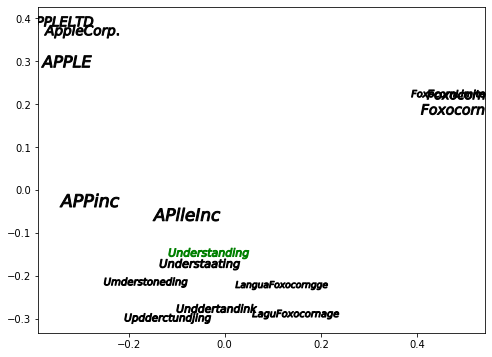

In [51]:
import sklearn.decomposition
import matplotlib.pyplot as plt


words = ['APlle Inc', 'Foxocorn Limited Corp', 'Understanding',
         'Apple Corp.', 'Foxocorn inc', 'Updderctundjing',
         'APPLE', 'Foxocorn', 'Understaating',
         'APP inc', 'LaguFoxocornage', 'Unddertandink',
         'APPLE LTD', 'LanguaFoxocorngge', 'Umderstoneding']

# Create word embeddings
word_embeddings = simcse_model.encode(words)

# Project embeddings on plane using the PCA
projection_2d = sklearn.decomposition.PCA(n_components=2).fit_transform(word_embeddings)

# Draw words on plane
f = plt.figure(figsize=(8, 6))

for j in range(len(projection_2d)):
    plt.scatter(projection_2d[j, 0], projection_2d[j, 1],
                marker=('$' + words[j] + '$'),
                s=500 * len(words[j]), label=j,
                facecolors='green' if words[j]
                            in ['Natural', 'Language', 'Understanding'] else 'black')

plt.show()

In [54]:
%%time
from random import randint

i = randint(0, len(a))

sent1 = a.iloc[i]['name']
sent2 = b.iloc[i]['name']

simcse_model.tokenizer.tokenize(sent1),\
simcse_model.tokenizer.tokenize(sent2),\
sent1,\
sent2,\
simcse_model.tokenizer.batch_encode_plus([sent1,sent2])

CPU times: user 2.4 ms, sys: 673 µs, total: 3.08 ms
Wall time: 1.95 ms


(['mc', 'sr', '##l'],
 ['mc', 's', '.', 'r', '.', 'l', '.'],
 'MC SRL',
 'MC S.r.l.',
 {'input_ids': [[101, 11338, 5034, 2140, 102], [101, 11338, 1055, 1012, 1054, 1012, 1048, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]]})

In [55]:
encoded = simcse_model.encode(a.norm_ws.tolist(), 
                batch_size=64,
                max_length= 20)

100%|██████████| 371/371 [00:02<00:00, 135.88it/s]


In [56]:
encoded_b = simcse_model.encode(b.norm_ws.tolist(), 
                batch_size=64,
                max_length= 20)

100%|██████████| 371/371 [00:02<00:00, 139.04it/s]


In [57]:
import torch
from torchmetrics.functional import pairwise_cosine_similarity

In [58]:
# C = torch.einsum('id,jd->ij', torch.tensor(word_embeddings_a),torch.tensor(word_embeddings_b)).numpy()
simcse_emb_sim = pairwise_cosine_similarity(torch.tensor(encoded),torch.tensor(encoded_b)).numpy()

/tmp/ipykernel_840/1793419373.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  simcse_emb_sim = pairwise_cosine_similarity(torch.tensor(encoded),torch.tensor(encoded_b)).numpy()


In [66]:
from tqdm import tqdm
correct = 0
mistakes= []
for i in tqdm(range(len(a))): 
    sim = simcse_emb_sim[i]
    sorted_data = np.argsort(sim,axis=0)
    top_sim = sorted_data[::-1][:15]
    if b.iloc[i]['name'] in b.iloc[top_sim].name.tolist():
        correct +=1
    else:
        mistakes.append({'a_name': a.iloc[i]['name'], 'b_name': b.iloc[i]['name'], 'sim': b.iloc[top_sim].name.tolist(),'scores':sim[top_sim]})

100%|██████████| 23685/23685 [00:45<00:00, 519.93it/s]


In [62]:
correct/len(a), correct

(0.9986067131095631, 23652)

In [65]:
pd.set_option('display.max_rows',50)
pd.set_option('display.max_colwidth',None)

pd.DataFrame(mistakes)

,a_name,b_name,sim,scores
0,ARB Bhd,ARB Berhad,"[ARYZTA AG, Argonne National Laboratory, Arlo Technologies, Inc., ArQule, Inc., ARRIS Technology, Inc., Arff Ltd, Arvind Limited, Rohde & Schwarz GmbH & Co. KG, Wonhe High-Tech International, Inc., Argan, Inc.]","[0.8552982, 0.8548779, 0.84439576, 0.8436462, 0.83937037, 0.8362359, 0.83240414, 0.8271892, 0.8130536, 0.8130367]"
1,ASEC SA,Asec Spolka Akcyjna,"[Asuragen, Inc., ASDERA LLC, ASE Korea, Inc., ASGN Incorporated, Asembia, Astika Holdings, Inc., Asesoramiento Bruch S.L., AST International, Aseptico, Inc., Asterias Biotherapeutics, Inc.]","[0.8922901, 0.8920481, 0.8852093, 0.87481755, 0.87131864, 0.86509407, 0.8623942, 0.861648, 0.8612921, 0.8580705]"
2,Altruis Group LLC,"Altrius Group, LLC","[Altria Group, Inc., eMedia Group Inc., EMC Insurance Group Inc., Altisource S.À R.L., REAC Group, Inc., Sumitomo Mitsui Financial Group, Inc., Sumitomo Mitsui Financial Group, Inc., Altec Industries, Inc., REV Group, Inc., Oben Holding Group S.A.C.]","[0.92264295, 0.85787165, 0.854352, 0.8518733, 0.8493804, 0.8461913, 0.8461913, 0.8450208, 0.84239376, 0.8403715]"
3,Apollo Acquisition Corp,Apolo Acquisition Corp.,"[ApolloBio Corp., Apollo Solar Energy, Inc., Apollovej Aps, Apollo Medical Holdings, Inc., Apollo Global Securities, LLC, Apollo Holdings Limited, Apollo Commercial Real Estate Finance, Inc., Apollo Residential Mortgage, Inc., Apollo Education Group, Inc., Apollo Electronics Sp Z O O]","[0.9487492, 0.8857626, 0.8758639, 0.87388766, 0.86533517, 0.8622784, 0.86111605, 0.85732204, 0.8544752, 0.8463139]"
4,CAPP,CAPP/USA,"[CapLine, CAP ApS, Capsugel US, LLC, Capsa S.R.L., Capri Holdings Limited, Capsugel, Capgemini SE, CAP IM Supply, Inc., Cap'ter Methanisation, Capstone Therapeutics Corp.]","[0.87612504, 0.871716, 0.8716587, 0.86650026, 0.8588246, 0.85234326, 0.8390504, 0.83229005, 0.8305428, 0.8245619]"
5,CARGO,CAR'GO,"[FreightCar America, Inc., Transportation Security Agency, The Transportation Security Administration, FLEETCOR Technologies, Inc., Fleet Management Solutions, Inc., FleetNet America, Inc., Transportation and Logistics Systems, Inc., Freightliner Australia Pty Ltd., FreightCar Rail Services, LLC, Fleet Laboratories Ltd.]","[0.8176307, 0.80577165, 0.78611517, 0.7847837, 0.7729336, 0.7728646, 0.7706685, 0.76939726, 0.7683836, 0.7659666]"
6,CG Consulting LLC,CG3 Consulting LLC,"[CGC Inc., BGC LLC, Challenge Mfg. Company, LLC, CGR63, LLC, CGG, ABG-Camuto, LLC, Cgt Company Limited, RGC Resources, Inc., CG Visions Inc., CCBCC Operations, LLC]","[0.9602274, 0.88710696, 0.8623779, 0.85275215, 0.85227203, 0.8453989, 0.8444853, 0.8442348, 0.84265685, 0.83740836]"
7,Cohen and Co Inc,"Cohn & Company, Inc.","[Best Buy Co., Inc., Conopco, Inc., Alco Inc., NMC, Inc., Eni US Operating Co., Inc., Revett Mining Company, Inc., Daniels Corporate Advisory Company, Inc., The Bank of New York Company, Inc., Connexity, Inc., Southern Nuclear Operating Company, Inc.]","[0.8268777, 0.80815864, 0.79910934, 0.7914149, 0.7904204, 0.78747845, 0.7873854, 0.7860084, 0.78377795, 0.7830011]"
8,Cure Pharmaceuticals Corp,CURE Pharmaceutical Corporation,"[Remedy Pharmaceuticals, Inc., Care Pharmaceuticals Pty Limited, Conatus Pharmaceuticals Inc., Belcher Pharmaceuticals, LLC, Medexus Pharmaceuticals Inc., Checkmate Pharmaceuticals, Inc., Reata Pharmaceuticals, Inc., Biotest Pharmaceuticals Corporation, Boehringer Ingelheim Biopharmaceuticals (China) Co., Ltd., Medison Pharma Limited]","[0.92161274, 0.9182515, 0.9036981, 0.8993929, 0.89658976, 0.8960027, 0.89562, 0.89362234, 0.89178824, 0.89056516]"
9,Customer Financial Services,Custer Financial Services,"[Community Financial Services, Inc., Provident Financial Services, Inc., Wahlstedt Sageryd Financial Services Ab, Ameriprise Financial Services, LLC, National Financial Services LLC, Customers Ltd., Customer Systems PLC, Discover Financial Services, AmTrust Financial Services, Inc., Citizens Financial Services, Inc.]","[0.90742433, 0.9064558, 0.88704

In [29]:

i = 0
sim = s[i]
sorted_data = np.argsort(sim,axis=0)
top_sim = sorted_data[::-1][1:30]

In [25]:
correct

1476

In [135]:
!pip install faiss-gpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 22.4 MB/s eta 0:00:0000:0100:01


In [136]:
simcse_model.build_index(a.name.tolist())

12/10/2022 21:38:12 - INFO - faiss.loader -   Loading faiss with AVX2 support.
12/10/2022 21:38:12 - INFO - faiss.loader -   Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
12/10/2022 21:38:12 - INFO - faiss.loader -   Loading faiss.
12/10/2022 21:38:12 - INFO - faiss.loader -   Successfully loaded faiss.
12/10/2022 21:38:12 - INFO - simcse.core -   Encoding embeddings for sentences...
100%|██████████| 371/371 [00:09<00:00, 37.58it/s]
12/10/2022 21:38:22 - INFO - simcse.core -   Building index...
12/10/2022 21:38:22 - INFO - simcse.core -   Use GPU-version faiss


RuntimeError: Error in virtual void faiss::gpu::StandardGpuResourcesImpl::initializeForDevice(int) at /project/faiss/faiss/gpu/StandardGpuResources.cpp:283: Error: 'err == cudaSuccess' failed: failed to cudaHostAlloc 268435456 bytes for CPU <-> GPU async copy buffer (error 2 out of memory)

In [ ]:
from random import randint

i = randint(0, len(a))
b.iloc[i]['name'], a.iloc[i]['name']

In [ ]:
results = simcse_model.search(queries=list(b.name))

In [ ]:
len(results)

In [131]:
results[0]

NameError: name 'results' is not defined